# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import statsmodels.api as sm

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
labels.head(3)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


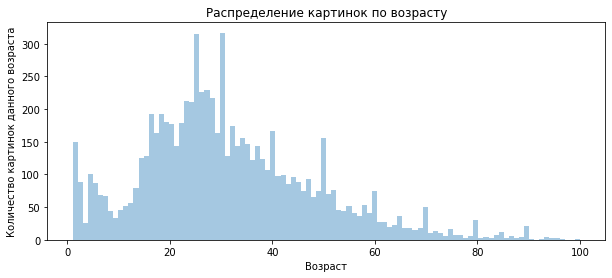

In [6]:
plt.figure(figsize=(10,4))
sns.distplot(labels.real_age, kde=False, bins=100)
plt.title('Распределение картинок по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Количество картинок данного возраста')
plt.show()

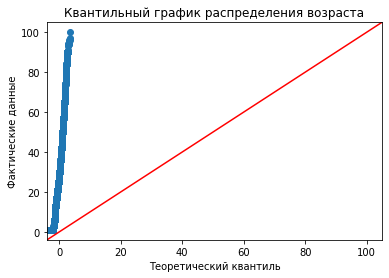

In [9]:
fig = sm.qqplot(labels.real_age, line='45')
plt.title('Квантильный график распределения возраста')
plt.xlabel('Теоретический квантиль')
plt.ylabel('Фактические данные')
plt.show()

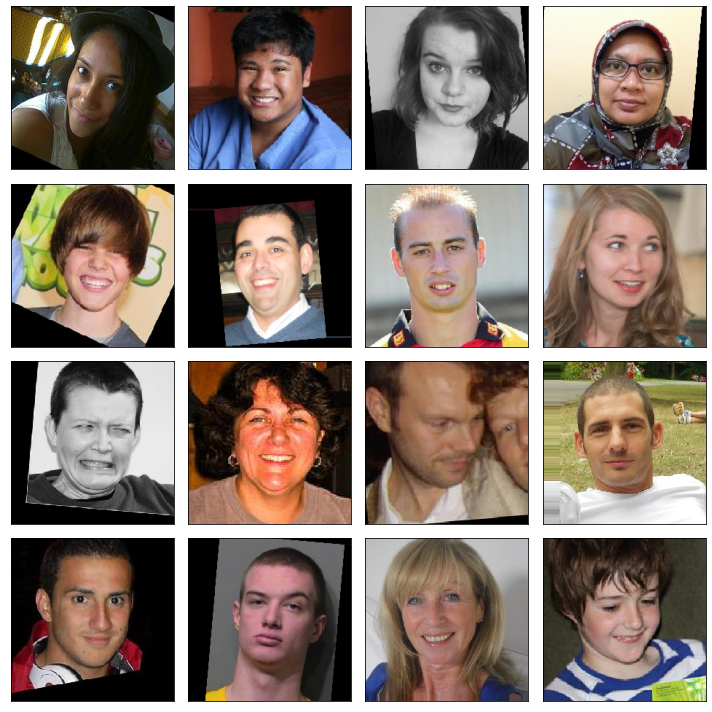

In [12]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

#!/usr/bin/env python
# coding: utf-8

# In[1]:


import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


# In[2]:


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow


# In[3]:


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


# In[4]:


def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model


# In[ ]:






```

#2023-07-31 13:22:29.961616: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2023-07-31 13:22:29.963422: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2023-07-31 13:22:30.856638: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-07-31 13:22:30.866341: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-07-31 13:22:30.866403: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-07-31 13:22:30.866434: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-07-31 13:22:30.868665: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-07-31 13:22:30.869088: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-07-31 13:22:30.871773: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-07-31 13:22:30.873068: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-07-31 13:22:30.873125: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-07-31 13:22:30.876616: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2023-07-31 13:22:31.047460: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2023-07-31 13:22:31.053915: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099995000 Hz
2023-07-31 13:22:31.054423: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4bfecb0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-07-31 13:22:31.054461: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-07-31 13:22:31.206831: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x425efd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-31 13:22:31.206863: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-07-31 13:22:31.208735: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-07-31 13:22:31.208793: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-07-31 13:22:31.208805: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-07-31 13:22:31.208832: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-07-31 13:22:31.208843: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-07-31 13:22:31.208854: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-07-31 13:22:31.208866: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-07-31 13:22:31.208873: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-07-31 13:22:31.212361: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2023-07-31 13:22:31.212446: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-07-31 13:22:31.725177: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-07-31 13:22:31.725228: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2023-07-31 13:22:31.725238: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2023-07-31 13:22:31.729282: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-07-31 13:22:31.729332: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 9s
   65536/94765736 [..............................] - ETA: 1:13
  262144/94765736 [..............................] - ETA: 40s 
  835584/94765736 [..............................] - ETA: 18s
 2359296/94765736 [..............................] - ETA: 8s 
 5758976/94765736 [>.............................] - ETA: 4s
10133504/94765736 [==>...........................] - ETA: 2s
13312000/94765736 [===>..........................] - ETA: 2s
18030592/94765736 [====>.........................] - ETA: 1s
22487040/94765736 [======>.......................] - ETA: 1s
25280512/94765736 [=======>......................] - ETA: 1s
29417472/94765736 [========>.....................] - ETA: 1s
33374208/94765736 [=========>....................] - ETA: 1s
34521088/94765736 [=========>....................] - ETA: 1s
37797888/94765736 [==========>...................] - ETA: 1s
39329792/94765736 [===========>..................] - ETA: 1s
43335680/94765736 [============>.................] - ETA: 1s
46104576/94765736 [=============>................] - ETA: 1s
49709056/94765736 [==============>...............] - ETA: 0s
51167232/94765736 [===============>..............] - ETA: 0s
54394880/94765736 [================>.............] - ETA: 0s
55910400/94765736 [================>.............] - ETA: 0s
60792832/94765736 [==================>...........] - ETA: 0s
62873600/94765736 [==================>...........] - ETA: 0s
66854912/94765736 [====================>.........] - ETA: 0s
70737920/94765736 [=====================>........] - ETA: 0s
71065600/94765736 [=====================>........] - ETA: 0s
75161600/94765736 [======================>.......] - ETA: 0s
79314944/94765736 [========================>.....] - ETA: 0s
83230720/94765736 [=========================>....] - ETA: 0s
83976192/94765736 [=========================>....] - ETA: 0s
87662592/94765736 [==========================>...] - ETA: 0s
91496448/94765736 [===========================>..] - ETA: 0s
92872704/94765736 [============================>.] - ETA: 0s
94773248/94765736 [==============================] - 2s 0us/step
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/20
2023-07-31 13:22:44.897352: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-07-31 13:22:45.378773: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 56s - loss: 221.5012 - mae: 11.2700 - val_loss: 407.2837 - val_mae: 15.1743
Epoch 2/20
356/356 - 46s - loss: 132.2852 - mae: 8.8522 - val_loss: 296.0554 - val_mae: 12.6476
Epoch 3/20
356/356 - 43s - loss: 110.2768 - mae: 8.0376 - val_loss: 134.1495 - val_mae: 9.1207
Epoch 4/20
356/356 - 42s - loss: 90.4266 - mae: 7.2703 - val_loss: 136.1911 - val_mae: 8.6464
Epoch 5/20
356/356 - 42s - loss: 78.7963 - mae: 6.8328 - val_loss: 159.2847 - val_mae: 10.3095
Epoch 6/20
356/356 - 42s - loss: 61.1902 - mae: 6.0464 - val_loss: 113.0046 - val_mae: 8.5432
Epoch 7/20
356/356 - 41s - loss: 58.8364 - mae: 5.8794 - val_loss: 90.2528 - val_mae: 7.2462
Epoch 8/20
356/356 - 38s - loss: 48.1894 - mae: 5.3237 - val_loss: 114.1831 - val_mae: 8.2972
Epoch 9/20
356/356 - 43s - loss: 43.4438 - mae: 5.0733 - val_loss: 108.4848 - val_mae: 7.8080
Epoch 10/20
356/356 - 44s - loss: 34.4072 - mae: 4.5148 - val_loss: 125.7629 - val_mae: 8.5743
Epoch 11/20
356/356 - 44s - loss: 32.5976 - mae: 4.3776 - val_loss: 121.2977 - val_mae: 8.1199
Epoch 12/20
356/356 - 44s - loss: 27.4328 - mae: 4.0347 - val_loss: 148.6615 - val_mae: 9.7611
Epoch 13/20
356/356 - 43s - loss: 26.5209 - mae: 3.9763 - val_loss: 112.2864 - val_mae: 8.2417
Epoch 14/20
356/356 - 44s - loss: 25.5700 - mae: 3.8955 - val_loss: 132.3384 - val_mae: 8.4649
Epoch 15/20
356/356 - 44s - loss: 24.4143 - mae: 3.7704 - val_loss: 94.0657 - val_mae: 7.4174
Epoch 16/20
356/356 - 43s - loss: 21.5975 - mae: 3.5705 - val_loss: 97.5439 - val_mae: 7.6429
Epoch 17/20
356/356 - 44s - loss: 17.5395 - mae: 3.2276 - val_loss: 92.0273 - val_mae: 7.4222
Epoch 18/20
356/356 - 44s - loss: 16.7762 - mae: 3.1482 - val_loss: 91.3362 - val_mae: 7.3525
Epoch 19/20
356/356 - 43s - loss: 16.1094 - mae: 3.0966 - val_loss: 83.3758 - val_mae: 6.7331
Epoch 20/20
356/356 - 44s - loss: 16.4572 - mae: 3.1172 - val_loss: 77.8090 - val_mae: 6.6000
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 77.8090 - mae: 6.6000
Test MAE: 6.6000

## Анализ обученной модели

В датасете 7591 фотографий

Большая часть возарста людей находится в диапазоне от 21 до 40 лет

Есть ЧБ фотографии, под углом, разных размеров, к тому же есть фото с лишними объектами перед лицом(жвачка, микрофон и пр.)

В целом общая ориненатция фотографий выстроена правильно, но опять же некоторые под довльно сильным углом

Для анализа возраста людей по фотографии была использована CCN ResNet50. 

Было задано 20 эпох и функция оптимизации для нахождения минимума Adam с шагом lr=0.0005. 

По итогам анализа мы получили значение метрики mean absolute error для обучающей и для валидационной выборки.

Значение mae для обучающей получилось 3.11, а для валидационной mae получилось 6.6. Модель немного переобучилась.

Но разница в 3 года думаю не значительным переобучением и могу сказать, что модель предсказывает хорошо.




## Чек-лист

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [ ]  MAE модели не больше 8
- [ ]  Код обучения модели скопирован в финальную тетрадь
- [ ]  Результат вывода модели на экран перенесён в финальную тетрадь
- [ ]  По итогам обучения модели сделаны выводы